In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(sc.__version__)

1.1.0


(0, 6)

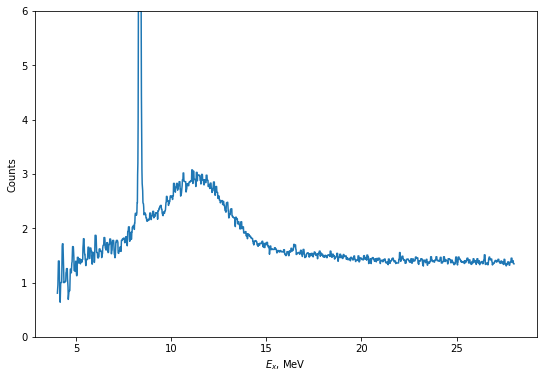

In [3]:
red_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/red data/4_28_red.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(red_4_28['x'].values, red_4_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

Text(0,0.5,'Counts')

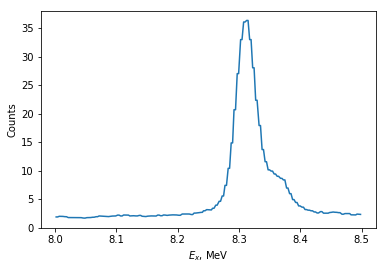

In [4]:
IAS_red = pd.read_csv('../B(GT) peaks processing/recognition/red data/IAS_red.csv', 
                      sep='\t', decimal=',')
plt.plot(IAS_red['x'].values, IAS_red['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

Text(0,0.5,'Counts')

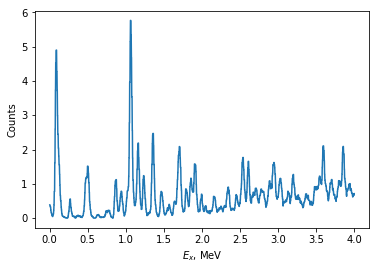

In [5]:
red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/red data/0_4_red.csv', 
                      sep='\t', decimal=',')
plt.plot(red_0_4['x'].values, red_0_4['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

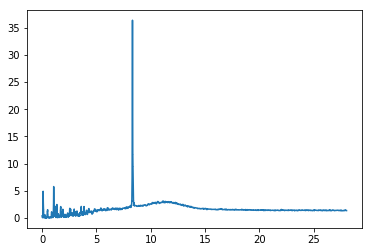

In [6]:
beginning = red_4_28[((red_4_28['x']<8.1))]
middle = IAS_red[((IAS_red['x']>8.1) & (IAS_red['x']<8.65))]
ending = red_4_28[((red_4_28['x']>8.65))]

data = red_0_4.append(beginning).append(middle).append(ending)

plt.plot(data['x'].values, data['y'].values)

(0, 16)

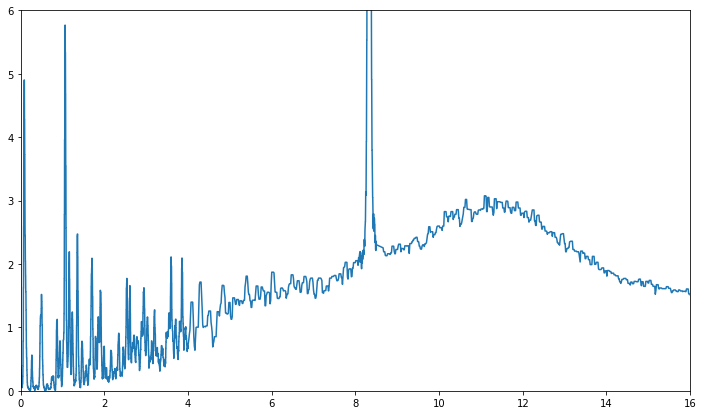

In [7]:
plt.figure(figsize=(12,7))
plt.plot(data['x'].values, data['y'].values)
plt.ylim(0,6)
plt.xlim(0,16)

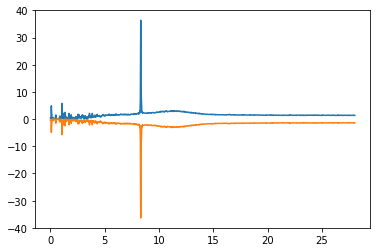

In [8]:
plt.plot(data['x'].values, data['y'].values)
plt.plot(data['x'].values, -data['y'].values)

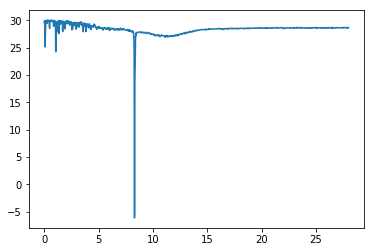

In [9]:
x_data = np.linspace(0,28,len(data['x'].values))
y_data = np.interp(x_data, data['x'].values, data['y'].values)
#plt.plot(x_data, y_data)
plt.plot(x_data, -y_data+30)

(0, 3000)

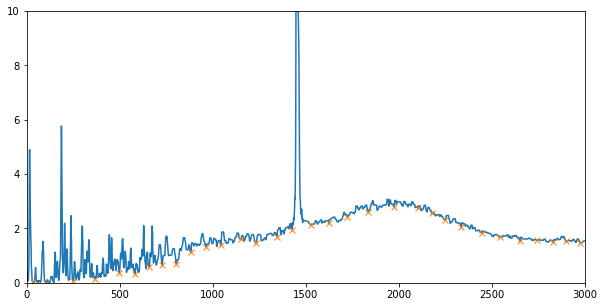

In [10]:
peaks, _ = sc.signal.find_peaks(-y_data+30, distance=70)
plt.figure(figsize=(10,5))
plt.plot(y_data)
plt.plot(peaks, y_data[peaks], "x")
plt.ylim(0,10)
plt.xlim(0,3000)

(8.2, 8.4)

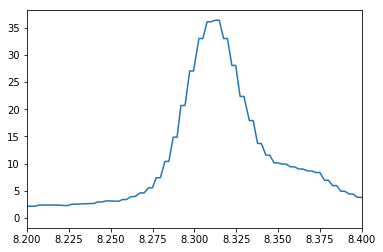

In [11]:
plt.plot(data['x'].values, data['y'].values)
plt.xlim(8.2,8.4)

(8, 9)

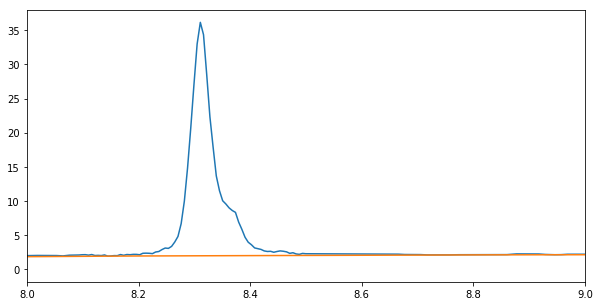

In [12]:
y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(x_data, y_data2)
plt.xlim(8,9)

(0, 10)

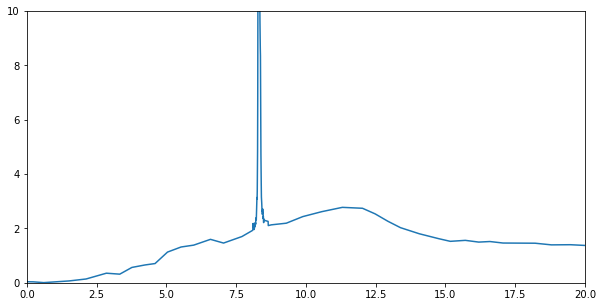

In [13]:
temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})

data3 = temp2[(temp2['x']<8.1)].append(temp1[((temp1['x']>8.1) & (temp1['x']<8.65))]).append(temp2[(temp2['x']>8.65)])

plt.figure(figsize=(10,5))
plt.plot(data3['x'].values, data3['y'].values)
plt.xlim(0,20)
plt.ylim(0,10)

In [14]:
np.random.seed(0) 

In [15]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [16]:
def QFC_back(E, E_qf, N_0, W = 22, T = 100):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    x = E_t_gs - E
    return N_0 * ( 1 - np.exp((x-E_0)/T) )/( 1 + ((x-E_qf)/W)**2)

def QFC_back2(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    return N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)

def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

[[Model]]
    ((Model(breit_vigner4, prefix='IAS1_') + Model(breit_vigner4, prefix='IAS2_')) + Model(line, prefix='line_'))
[[Fit Statistics]]
    # function evals   = 10345
    # data points      = 187
    # variables        = 8
    chi-square         = 132.798
    reduced chi-square = 0.742
    Akaike info crit   = -48.007
    Bayesian info crit = -22.158
[[Variables]]
    IAS1_M:    7.94421182 (init= 5)
    IAS1_w:    8.31175827 (init= 8.308)
    IAS1_G1:   0.03494138 (init= 0.01)
    IAS2_M:    1.10035814 (init= 5)
    IAS2_w:    8.36539910 (init= 8.36)
    IAS2_G1:   0.04148743 (init= 0.005)
    line_a:    0.16402182 (init= 0.001)
    line_b:    0.06103193 (init= 0.001)



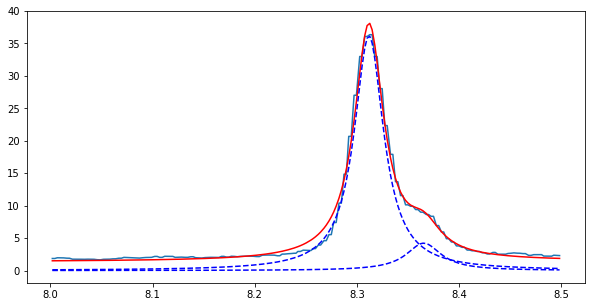

In [17]:
np.random.seed(0)

IAS_mod = Model(breit_vigner4,prefix='IAS1_')+Model(breit_vigner4,prefix='IAS2_')+Model(line, prefix='line_')

IAS_mod.set_param_hint('IAS1_w', value=8.308, min=8.3, max=8.32)
IAS_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=1)
IAS_mod.set_param_hint('IAS1_M', value=5, min=1, max= 20)

IAS_mod.set_param_hint('IAS2_w', value=8.36, min=8.3, max=8.4)
IAS_mod.set_param_hint('IAS2_G1', value=0.005, min=0.005, max=3)
IAS_mod.set_param_hint('IAS2_M', value=5, min=0.01, max=15)

IAS_mod.set_param_hint('line_a', value=0.001, min=0.001, max=3)
IAS_mod.set_param_hint('line_b', value=0.001, min=0.001, max=3)
pars = IAS_mod.make_params()

IAS_result = IAS_mod.fit(IAS_red['y'].values, pars, x=IAS_red['x'].values, method='differential_evolution')


print(IAS_result.fit_report())

comps = IAS_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(IAS_red['x'].values, IAS_red['y'].values)
plt.plot(IAS_red['x'].values, IAS_result.best_fit, 'r-')
plt.plot(IAS_red['x'].values, comps['IAS1_'], 'b--')
plt.plot(IAS_red['x'].values, comps['IAS2_'], 'b--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')

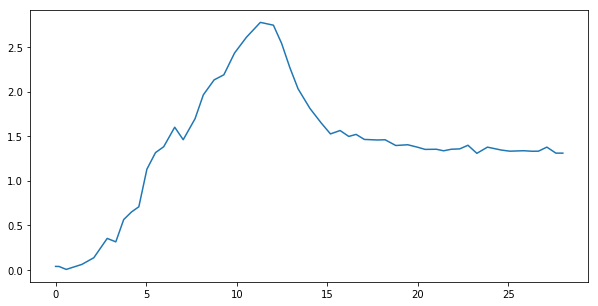

In [18]:
plt.figure(figsize=(10,5))
plt.plot(temp2['x'].values, temp2['y'].values)

In [19]:
np.random.seed(1)

mod = Model(breit_vigner4,prefix='pigmy1_')+Model(breit_vigner4, prefix='GTR_')+Model(breit_vigner4, prefix='SDR_')+Model(QFC_back3, prefix='QFC_back_')

mod.set_param_hint('pigmy1_w', value=6, min=5, max=7)
mod.set_param_hint('pigmy1_G1', value=0.01, min=0.1, max=10)
mod.set_param_hint('pigmy1_M', value=0.5, min=0.1, max= 50)

mod.set_param_hint('GTR_w', value=11.0, min=10.5, max=11.5)
mod.set_param_hint('GTR_G1', value=0.01, min=0.1, max=10)
mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 50)

mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=300 )
mod.set_param_hint('QFC_back_N_0', value=8, max=20, min=1 )
mod.set_param_hint('QFC_back_W', value=22, vary=False)
mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = mod.make_params()

mod_result = mod.fit(temp2['y'].values, pars, x=temp2['x'].values, method='differential_evolution')

print(mod_result.fit_report())

[[Model]]
    (((Model(breit_vigner4, prefix='pigmy1_') + Model(breit_vigner4, prefix='GTR_')) + Model(breit_vigner4, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 14086
    # data points      = 4893
    # variables        = 11
    chi-square         = 81.648
    reduced chi-square = 0.017
    Akaike info crit   = -20005.730
    Bayesian info crit = -19934.278
[[Variables]]
    pigmy1_M:        41.3314689 (init= 0.5)
    pigmy1_w:        6.99999436 (init= 6)
    pigmy1_G1:       5.03290348 (init= 0.1)
    GTR_M:           49.9964002 (init= 0.5)
    GTR_w:           11.2836683 (init= 11)
    GTR_G1:          3.90021160 (init= 0.1)
    SDR_M:           18.1156701 (init= 0.5)
    SDR_w:           18.0000265 (init= 18.5)
    SDR_G1:          9.97637935 (init= 0.1)
    QFC_back_E_qf:   409.982365 (init= 400)
    QFC_back_N_0:    11.4406175 (init= 8)
    QFC_back_W:      22 (fixed)
    QFC_back_T:      100 (fixed)



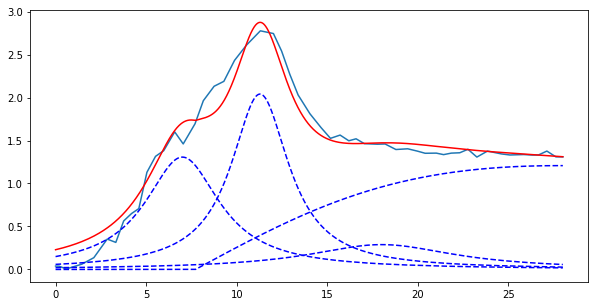

In [20]:

mod_comps = mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(temp2['x'].values, mod_result.best_fit, 'r-')
plt.plot(temp2['x'].values, mod_comps['pigmy1_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['GTR_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['SDR_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['QFC_back_'], 'b--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')

In [21]:
np.random.seed(2)

#mod = Model(breit_vigner3,prefix='pigmy1_')+Model(breit_vigner3,prefix='IAS1_')+Model(breit_vigner3,prefix='IAS2_')+Model(breit_vigner3, prefix='GTR_')+Model(breit_vigner3, prefix='SDR_')+Model(QFC_back3, prefix='QFC_back_')
mod = Model(breit_vigner3,prefix='pigmy1_')+Model(breit_vigner3, prefix='GTR_')+Model(breit_vigner3, prefix='SDR_')+Model(QFC_back3, prefix='QFC_back_')

mod.set_param_hint('pigmy1_w', value=6, min=5, max=7)
mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=2)
mod.set_param_hint('pigmy1_M', value=0.5, min=0.1, max= 50)

#mod.set_param_hint('IAS1_w', value=8.308, vary=False)
#mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
#mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
#mod.set_param_hint('IAS2_w', value=8.36, vary=False)
#mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
#mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=300 )
mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
mod.set_param_hint('QFC_back_W', value=22, vary=False)
mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = mod.make_params()

mod_result = mod.fit(temp2['y'].values, pars, x=temp2['x'].values, method='differential_evolution')

print(mod_result.fit_report())

[[Model]]
    (((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 31981
    # data points      = 4893
    # variables        = 11
    chi-square         = 14.371
    reduced chi-square = 0.003
    Akaike info crit   = -28505.831
    Bayesian info crit = -28434.380
[[Variables]]
    pigmy1_M:        1.35632530 (init= 0.5)
    pigmy1_w:        6.31713771 (init= 6)
    pigmy1_G1:       1.99787316 (init= 0.1)
    GTR_M:           7.87512747 (init= 0.5)
    GTR_w:           11.0229470 (init= 11)
    GTR_G1:          3.30322450 (init= 2)
    SDR_M:           2.18611225 (init= 0.5)
    SDR_w:           18.9968697 (init= 18.5)
    SDR_G1:          5.20371158 (init= 0.1)
    QFC_back_E_qf:   393.499832 (init= 400)
    QFC_back_N_0:    6.39668743 (init= 8)
    QFC_back_W:      22 (fixed)
    QFC_back_T:      100 (fixed)



(0, 6)

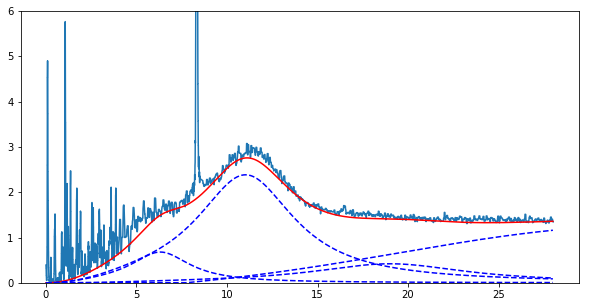

In [22]:
mod_comps = mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(temp2['x'].values, mod_result.best_fit, 'r-')
plt.plot(temp2['x'].values, mod_comps['pigmy1_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['GTR_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['SDR_'], 'b--')
plt.plot(temp2['x'].values, mod_comps['QFC_back_'], 'b--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.ylim(0,6)

In [24]:
np.random.seed(3)

total_mod = Model(breit_vigner3,prefix='pigmy1_')+Model(breit_vigner3,prefix='IAS1_')+Model(breit_vigner3,prefix='IAS2_')+Model(breit_vigner3, prefix='GTR_')+Model(breit_vigner3, prefix='SDR_')+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=6, min=5, max=7)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=2)
total_mod.set_param_hint('pigmy1_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=300 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 27481
    # data points      = 4893
    # variables        = 15
    chi-square         = 154.432
    reduced chi-square = 0.032
    Akaike info crit   = -16879.250
    Bayesian info crit = -16781.817
[[Variables]]
    pigmy1_M:        1.17949831 (init= 0.5)
    pigmy1_w:        6.27416583 (init= 6)
    pigmy1_G1:       1.53898956 (init= 0.1)
    IAS1_M:          0.56142674 (init= 0.5)
    IAS1_w:          8.308 (fixed)
    IAS1_G1:         0.01654785 (init= 0.01)
    IAS2_M:          0.15549075 (init= 0.1)
    IAS2_w:          8.36 (fixed)
    IAS2_G1:         0.02994466 (init= 0.03)
    GTR_M:           7.46705757 (init= 0.5)
    GTR_w:           11.0431985 (init= 11)
    GTR_G1:          3

(0, 6)

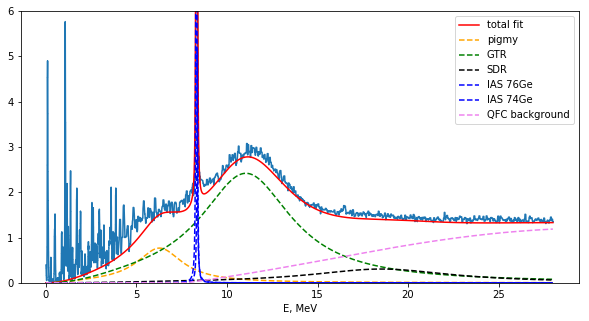

In [25]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
#plt.savefig("test1.png", transparent=False, dpi=120)

(8, 9)

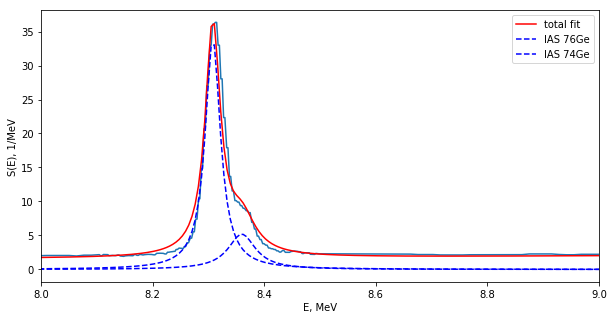

In [26]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.ylabel('S(E), 1/MeV')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.xlim(8,9)
#plt.savefig("test.png", transparent=False)

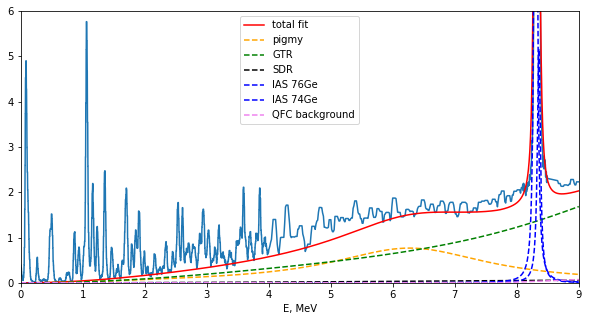

In [27]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.xlim(0,9)
plt.ylim(0,6)
plt.savefig("test.png", transparent=False, dpi=120)

(0, 6)

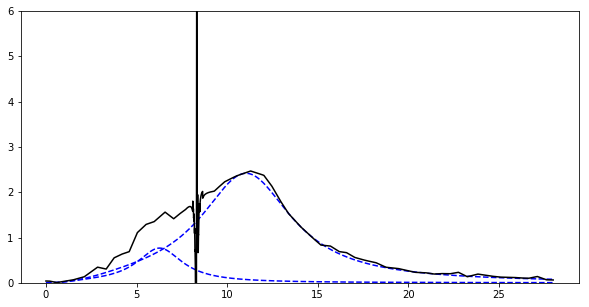

In [28]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
#plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'b--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'b--')
#plt.plot(data3['x'].values, data3['y'].values-total_mod_result.best_fit )
a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
plt.plot(data3['x'].values, data3['y'].values-a, 'black' )
plt.ylim(0,6)

In [29]:
np.random.seed(150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=2, min=1, max=4)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=0.6)
total_mod.set_param_hint('pigmy1_M', value=0.1, min=0.1, max=0.4)

total_mod.set_param_hint('pigmy2_w', value=3, min=2, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.3, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=6, min=5, max=7)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.5, max=0.8)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 35069
    # data points      = 4893
    # variables        = 21
    chi-square         = 154.774
    reduced chi-square = 0.032
    Akaike info crit   = -16856.452
    Bayesian info crit = -16720.046
[[Variables]]
    pigmy1_M:        0.10014413 (init= 0.1)
    pigmy1_w:        3.97358781 (init= 2)
    pigmy1_G1:       0.59741298 (init= 0.1)
    pigmy2_M:        0.30021597 (init= 0.3)
    pigmy2_w:        5.52563891 (init= 3)
    pigmy2_G1:       0.64293168 (init= 0.1)
    pigmy3_M:        0.55536357 (init= 0.5)
    pigmy3_w:        6.67050878 (init= 6)
    pigmy3_G1:       0.98547037 (init= 0.1)
    IAS1_M

(0, 6)

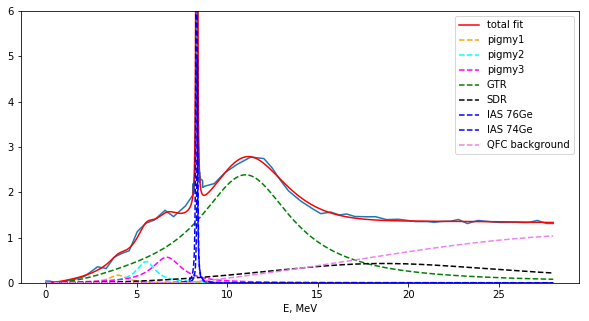

In [30]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 6)

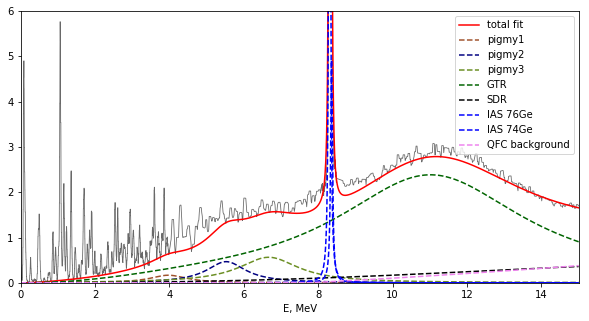

In [31]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values, 'dimgrey', linewidth=0.8)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'sienna', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'navy', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'olivedrab', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'darkgreen', label='GTR',  ls='--')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.xlim(0,15)
plt.ylim(0,6)
#plt.savefig("test.png", transparent=False, dpi=120)

(0, 6)

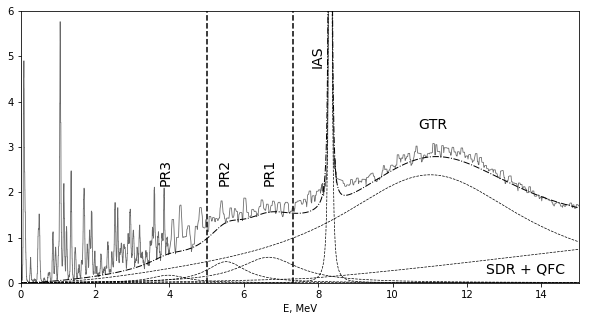

In [32]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values, 'dimgrey', linewidth=0.8)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', label='total fit', 
         linewidth=1, ls='-.')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='pigmy1', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='pigmy2', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'k', label='pigmy3', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR',  ls='--',
        linewidth=0.7)

IAS = total_mod_comps['IAS1_'] + total_mod_comps['IAS2_']
plt.plot(data3['x'].values, IAS, 'k', label='IAS', ls='--',
        linewidth=0.7)
SDR_QFC = total_mod_comps['SDR_'] + total_mod_comps['QFC_back_']
plt.plot(data3['x'].values, SDR_QFC, 'k', label='SDR + QFC', ls='--',
        linewidth=0.7)
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
#plt.legend()
#plt.arrow(11,1,1,-0.5, width=0.02, head_width=5*0.02, color='k')
plt.axvline(5, c='k', ls='--')
plt.axvline(7.328, c='k', ls='--')
plt.text(10.7, 3.4, 'GTR',  fontsize=14)
plt.text(12.5, 0.2, 'SDR + QFC',  fontsize=14)
plt.text(7.8, 5.0, 'IAS',  fontsize=14, rotation=90)
plt.text(6.5, 2.5, 'PR1',  fontsize=14, rotation=90)
plt.text(5.3, 2.5, 'PR2',  fontsize=14, rotation=90)
plt.text(3.7, 2.5, 'PR3',  fontsize=14, rotation=90)
plt.xlabel('E, MeV')
plt.xlim(0,15)
plt.ylim(0,6)
#plt.savefig("all_fit_0_15.png", transparent=False, dpi=500)

(0, 2.5)

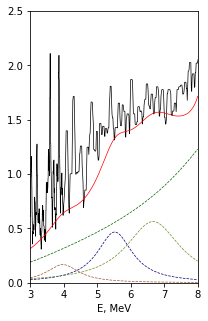

In [33]:
plt.figure(figsize=(3,5))
plt.plot(data['x'].values, data['y'].values, 'k', linewidth=0.7)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit', 
         linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'sienna', label='pigmy1', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'navy', label='pigmy2', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'olivedrab', label='pigmy3', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'darkgreen', label='GTR',  ls='--',
        linewidth=0.7)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
#plt.legend()
plt.xlabel('E, MeV')
plt.xlim(3,8)
plt.ylim(0,2.5)
#plt.savefig("test.png", transparent=False, dpi=120)

(0, 2.5)

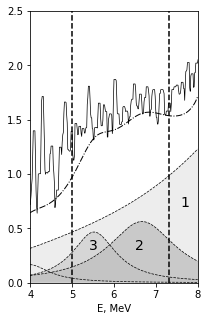

In [34]:
plt.figure(figsize=(3,5))
plt.plot(data['x'].values, data['y'].values, 'k', linewidth=0.7)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)

plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'k', label='pigmy1', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'k', label='pigmy2', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'k', label='pigmy3', ls='--',
        linewidth=0.7)
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'k', label='GTR',  ls='--',
        linewidth=0.7)


plt.plot(data3['x'].values, total_mod_result.best_fit, 'k', label='total fit', 
         linewidth=1, ls='-.')
plt.fill(data3['x'].values, total_mod_comps['GTR_'], 'gainsboro', label='GTR', alpha=0.5)
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'grey', label='pigmy1', ls='--',
#        linewidth=0.9)
plt.fill(data3['x'].values, total_mod_comps['pigmy2_'], 'silver', label='pigmy2', 
         alpha=0.5)
plt.fill(data3['x'].values, total_mod_comps['pigmy3_'], 'silver', label='pigmy3', 
         alpha=0.8)
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
#plt.legend()
plt.axvline(5, c='k', ls='--')
plt.axvline(7.328, c='k', ls='--')
plt.text(7.6, 0.7, '1',  fontsize=14)
plt.text(6.5, 0.3, '2',  fontsize=14)
plt.text(5.4, 0.3, '3',  fontsize=14)
plt.xlabel('E, MeV')
plt.xlim(4,8)
plt.ylim(0,2.5)
#plt.savefig("all_fit_4_8.png", transparent=False, dpi=500)

(0, 6)

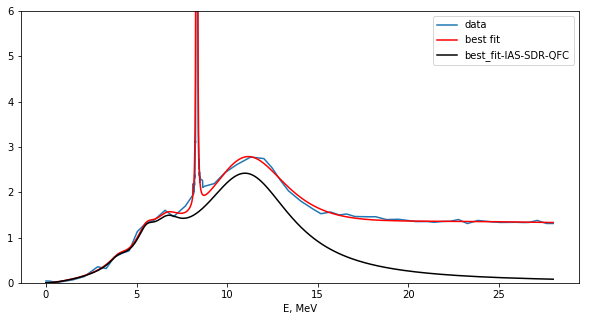

In [35]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values, label='data')
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='best fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'b--')
#plt.plot(data3['x'].values, data3['y'].values-total_mod_result.best_fit )
a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
out = total_mod_result.best_fit-a
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)

(8, 9)

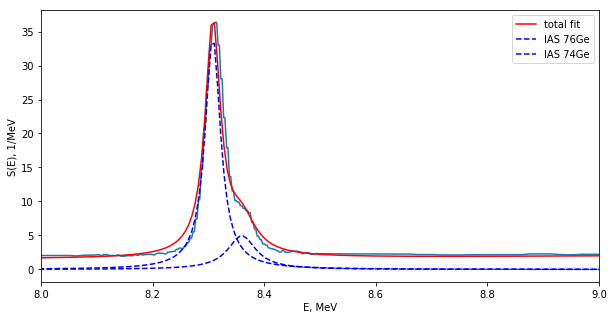

In [36]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.ylabel('S(E), 1/MeV')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.xlim(8,9)

In [37]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T, 
                          'GTR':total_mod_comps['GTR_'].T, 
                         'PR1':total_mod_comps['pigmy1_'].T,
                         'PR2':total_mod_comps['pigmy2_'].T,
                         'PR3':total_mod_comps['pigmy3_'].T})
output.head()              

,GTR,PR1,PR2,PR3,x,y
0,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.005724,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.011447,0.00000
3,0.00001,0.00000,0.00000,0.00000,0.017171,0.00001
4,0.00001,0.00001,0.00001,0.00001,0.022895,0.00004


In [38]:
#output.to_csv('best_fit_3PR-SDR-IAS-QFC.csv')

In [41]:
np.random.seed(1150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(gauss, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=2, min=1, max=4)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=0.6)
total_mod.set_param_hint('pigmy1_M', value=0.1, min=0.1, max=0.4)

total_mod.set_param_hint('pigmy2_w', value=3, min=2, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.3, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=6, min=5, max=7)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.5, max=0.8)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_mu', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_sigma', value=2, min=0.1, max=20)
total_mod.set_param_hint('GTR_k', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(gauss, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 39069
    # data points      = 4893
    # variables        = 21
    chi-square         = 156.475
    reduced chi-square = 0.032
    Akaike info crit   = -16802.969
    Bayesian info crit = -16666.562
[[Variables]]
    pigmy1_M:        0.13632985 (init= 0.1)
    pigmy1_w:        3.61543017 (init= 2)
    pigmy1_G1:       0.57949684 (init= 0.1)
    pigmy2_M:        0.57328830 (init= 0.3)
    pigmy2_w:        5.27854522 (init= 3)
    pigmy2_G1:       0.88186544 (init= 0.1)
    pigmy3_M:        0.78719150 (init= 0.5)
    pigmy3_w:        6.53577107 (init= 6)
    pigmy3_G1:       0.99768456 (init= 0.1)
    IAS1_M:       

(0, 6)

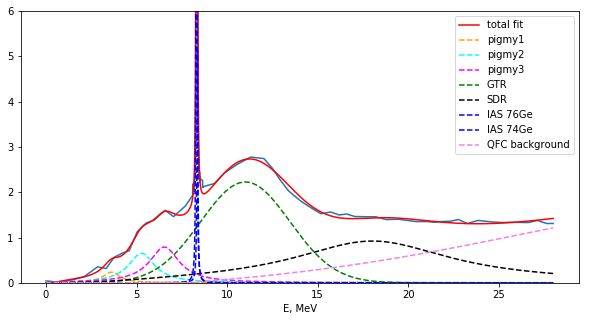

In [42]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 6)

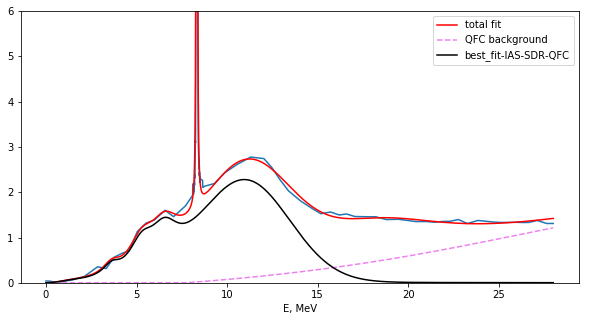

In [44]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')

a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
out = total_mod_result.best_fit-a

plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

In [49]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T, 
                          'GTR_gauss':total_mod_comps['GTR_'].T, 
                         'PR1':total_mod_comps['pigmy1_'].T,
                         'PR2':total_mod_comps['pigmy2_'].T,
                         'PR3':total_mod_comps['pigmy3_'].T})
output.head() 
output.to_csv('3pigmy_gauss-SDR-IAS-QFC.csv')

In [48]:
output.head()

,GTR_gauss,PR1,PR2,PR3,x,y
0,0.000105,0.00000,0.00000,0.00000,0.000000,0.000105
1,0.000106,0.00000,0.00000,0.00000,0.005724,0.000106
2,0.000107,0.00000,0.00000,0.00000,0.011447,0.000107
3,0.000108,0.00001,0.00001,0.00001,0.017171,0.000138
4,0.000109,0.00001,0.00001,0.00001,0.022895,0.000139


In [38]:
np.random.seed(250)

total_mod = Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='pigmy3_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3,prefix='IAS2_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back3, prefix='QFC_back_')

total_mod.set_param_hint('pigmy2_w', value=3, min=1, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1)
total_mod.set_param_hint('pigmy2_M', value=0.1, min=0.3, max=0.6)

total_mod.set_param_hint('pigmy3_w', value=6, min=4, max=7)
total_mod.set_param_hint('pigmy3_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy3_M', value=0.1, min=0.5, max=1)

total_mod.set_param_hint('IAS1_w', value=8.308, vary=False)
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.02)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=0.7)
total_mod.set_param_hint('IAS2_w', value=8.36, vary=False)
total_mod.set_param_hint('IAS2_G1', value=0.03, min=0.01, max=0.05)
total_mod.set_param_hint('IAS2_M', value=0.1, min=0.1, max=0.5)

total_mod.set_param_hint('GTR_w', value=11.0, min=11, max=11.5)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=4)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 50)

total_mod.set_param_hint('SDR_w', value=18.5, min=18, max=19)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 5)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, max=15, min=1 )
total_mod.set_param_hint('QFC_back_W', value=22, vary=False)
total_mod.set_param_hint('QFC_back_T', value=100,vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((((Model(breit_vigner3, prefix='pigmy2_') + Model(breit_vigner3, prefix='pigmy3_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='IAS2_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back3, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 39394
    # data points      = 4893
    # variables        = 18
    chi-square         = 152.836
    reduced chi-square = 0.031
    Akaike info crit   = -16924.087
    Bayesian info crit = -16807.167
[[Variables]]
    pigmy2_M:        0.32683238 (init= 0.3)
    pigmy2_w:        5.42878895 (init= 3)
    pigmy2_G1:       0.94324853 (init= 0.1)
    pigmy3_M:        0.85726053 (init= 0.5)
    pigmy3_w:        6.57612420 (init= 6)
    pigmy3_G1:       1.45206182 (init= 0.1)
    IAS1_M:          0.56445080 (init= 0.5)
    IAS1_w:          8.308 (fixed)
    IAS1_G1:         0.01675688 (init= 0.01)
    IAS2_M:          0.15300489 (init= 0.1)
    IAS2_w:    

(0, 6)

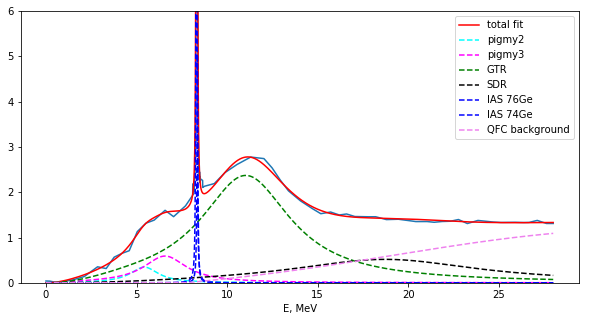

In [39]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

(0, 6)

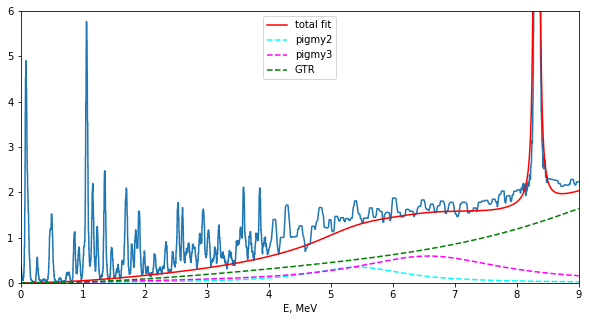

In [40]:
plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
plt.xlim(0,9)
plt.ylim(0,6)
#plt.savefig("test.png", transparent=False, dpi=120)

(0, 6)

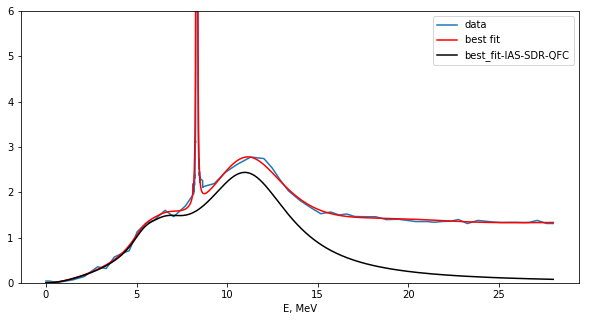

In [41]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values, label='data')
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='best fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'b--')
#plt.plot(data3['x'].values, data3['y'].values-total_mod_result.best_fit )
a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+total_mod_comps['IAS2_']
out = total_mod_result.best_fit-a
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)

In [42]:
output=pd.DataFrame(data={'x':data3['x'].values.T, 'y':out.T})
output.to_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

(0, 6)

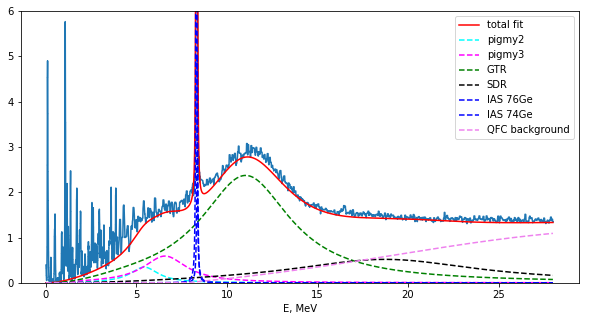

In [46]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)

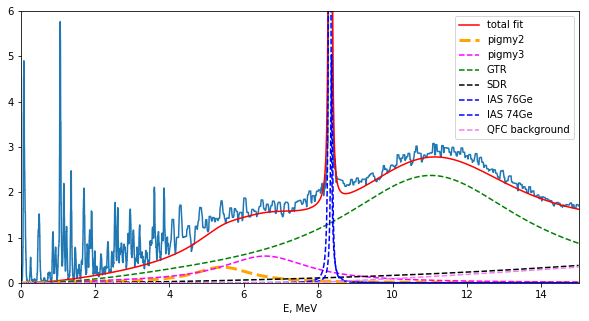

In [58]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(10,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'orange', linewidth=3.0,
         label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(0,15)
plt.savefig("all_fit_0_15.png", transparent=False, dpi=120)

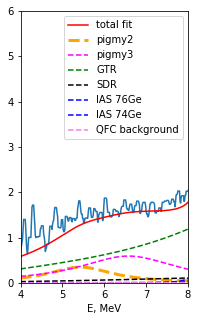

In [59]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(3,5))
plt.plot(data['x'].values, data['y'].values)
#plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'orange', linewidth=3.0,
         label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS 76Ge')
plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--', label='IAS 74Ge')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,6)
plt.xlim(4,8)
plt.savefig("all_fit_4_8.png", transparent=False, dpi=120)

(0, 6)

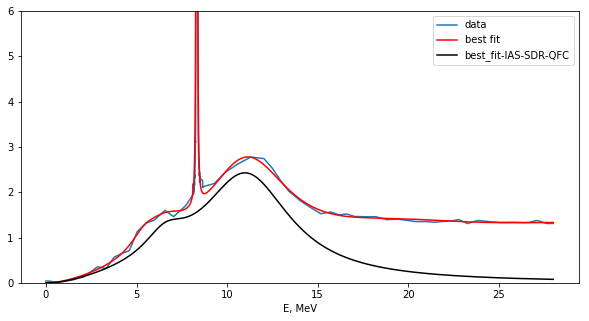

In [48]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values, label='data')
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='best fit')
#plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['pigmy3_'], 'magenta', label='pigmy3', ls='--')
#plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['IAS2_'], 'b--')
#plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'b--')
#plt.plot(data3['x'].values, data3['y'].values-total_mod_result.best_fit )
a = total_mod_comps['QFC_back_']+total_mod_comps['SDR_']+total_mod_comps['IAS1_']+ \
total_mod_comps['IAS2_']+total_mod_comps['pigmy2_']
out = total_mod_result.best_fit-a
plt.plot(data3['x'].values, out, c='black', label='best_fit-IAS-SDR-QFC' )
plt.xlabel('E, MeV')
plt.legend()
plt.ylim(0,6)